In [1]:
import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import torchvision.models as models
import hiddenlayer as hl
from tqdm import tqdm
from torch import optim
import numpy
from torch.utils.data import DataLoader
from utils.OpenSetCows2021 import OpenSetCows2021TrackLet

class ResNetMod(nn.Module):
    def __init__(self, numClasses, embeddingSize=128):
        """Initialize the model

        Parameters
        ----------
        numClasses : Int
            Number of classes (or individuals in a dataset)
        embeddingSize : Int, optional
            Size of the final embedding used differentiate individuals

        Returns
        -------
        A ResNetMod class instance
        """
        super(ResNetMod, self).__init__()

        # We create a resnet50 block and load imagenet weight into it
        self.backbone = models.resnet50(pretrained=True)
        imagenetWeights = model_zoo.load_url(
            "https://download.pytorch.org/models/resnet50-19c8e357.pth"
        )
        self.backbone.load_state_dict(imagenetWeights)

        # These layers are trained again, bias is set to true.
        self.backbone.fc = nn.Linear(2048, 1000)
        self.relu = nn.ReLU(inplace=True)
        self.embedding = nn.Linear(1000, embeddingSize)
        self.softmax = nn.Linear(1000, numClasses)

    def forwardOnce(self, x):
        """Forward through the network once

        Parameters
        ----------
        x : Input image to embed
            [Batch Size, Channel, Width, Height]

        Returns
        -------
        Embedding
            [Batch Size, 128]
        Softmax
            [Batch Size, Num Classes]
        """

        # Conv1 -> Relu(bn1) -> maxpool
        x = self.backbone.maxpool(
            self.backbone.relu(self.backbone.bn1(self.backbone.conv1(x)))
        )
        # avgpool(Layer 1 -> Layer 2 -> Layer 3 -> Layer 4)
        x = self.backbone.avgpool(
            self.backbone.layer4(
                self.backbone.layer3(self.backbone.layer2(self.backbone.layer1(x)))
            )
        )
        # Relu(FC)
        x = self.relu(self.backbone.fc(x.view(x.size(0), -1)))
        return self.embedding(x), self.softmax(x)

    def forward(self, anchor, negative=None, positive=None):
        """Forward the network

        Parameters
        ----------
        anchor : Input image to embed
            [Batch Size, Channel, Width, Height]
        negative : Input image, optional
            [Batch Size, Channel, Width, Height] used during
            training with Triplet loss
        positive : Input image, optional
            [Batch Size, Channel, Width, Height] used during
            training with Triplet loss

        Returns
        -------
        list
            Embeddings and softmax ouputs for negative, anchor,
            and postive triplets in case nagative and postive
            image inputs are provided. Otherwise, returns a
            single embedding and softmax output.
        """
        if (negative != None) & (positive != None):
            negativeEMBD, negativeSMax = self.forwardOnce(negative)
            anchorEMBD, anchorSMax = self.forwardOnce(anchor)
            positiveEMBD, positiveSMax = self.forwardOnce(positive)
            return (
                negativeEMBD,
                anchorEMBD,
                positiveEMBD,
                torch.cat((negativeSMax, anchorSMax, positiveSMax), 0),
            )
        else:
            anchorEMBD, anchorSMax = self.forwardOnce(anchor)
            return anchorEMBD, anchorSMax

    def __repr__(self):
        summary = f"{self.backbone.conv1.__repr__()} \n{self.backbone.bn1.__repr__()}"
        summary += "\nResnet Backbone: \n"
        layers = [
            self.backbone.layer1,
            self.backbone.layer2,
            self.backbone.layer3,
            self.backbone.layer4,
        ]
        for layer in layers:
            parameters = list(layer.named_parameters())
            summary += (
                f"\t ⎣ Input: {list(parameters[0][1].size())}"
                + f" -> Output: {list(parameters[-1][1].size())} ↩\n"
            )
        summary += self.backbone.fc.__repr__()
        summary += "\nOutput 1: " + self.embedding.__repr__()
        summary += "\nOutput 2: " + self.softmax.__repr__()
        return summary


In [3]:
class LRResNetMod(nn.Module):
    def __init__(self, numClasses, embeddingSize=128):
        super(LRResNetMod, self).__init__()
        self.ResnetMod = ResNetMod(numClasses, embeddingSize=embeddingSize)
        self.lstm = torch.nn.LSTM(input_size=embeddingSize, hidden_size=embeddingSize, num_layers=1, batch_first=True)
        self.FC = torch.nn.Linear(embeddingSize, numClasses)
    def forward(self, x):
        # x has the following shape: 
        # [
        #     Batch,
        #     sequence length (needs to be same for accross the batch, dynamic batching will be add later),
        #     channel,
        #     image height, image width
        # ]
        sequences = []
        # for every s
        for sequence in x:
            sequence, _ = self.ResnetMod(sequence) # Ignoring the classification output
            sequences.append(sequence)
        # Batch, number of images in each sequence, embddeing size
        seqeunces = torch.stack(sequences)
        # Batch, number of images in each sequence, embddeing size
        x, _ = self.lstm(seqeunces)
        # Batch, numclasses
        return self.FC(x)[:,-1,:]


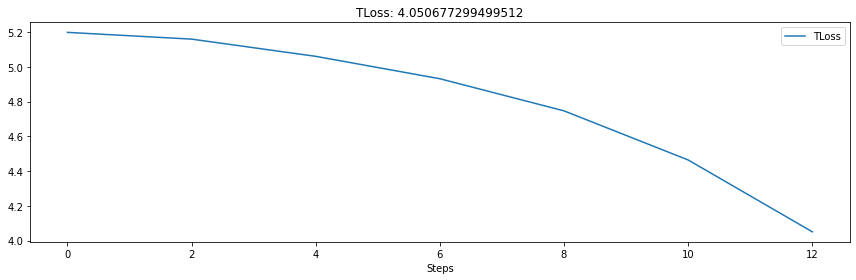

Training epochs:   6%|▋         | 13/200 [02:06<28:59,  9.30s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x127a02820>
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/metricLearning/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/metricLearning/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/metricLearning/lib/python3.8/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/metricLearning/lib/python3.8/multiprocessing/popen_fork.py", line 44, in wait
    if not wait([self.sentinel], timeout):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/metricLearning/lib/python3.8/multiproc

In [14]:
trainingDataset = OpenSetCows2021TrackLet('/Users/as16542/Downloads/4vnrca7qw1642qlwxjadp87h7', 'utils/opecowsTracklets.json', transform=True)
trainingDataLoader = DataLoader(
    trainingDataset, batch_size=3, num_workers=1, shuffle=False
)

# Get the device, prefer Cuda over CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# There are 182 individuals in the dataset
model = LRResNetMod(182)
model.to(device)

# We will use cross entropy loss for the training
lossFN = nn.CrossEntropyLoss()

loss, numEpochs = 0, 200

# To store the training history
history, canvas = hl.History(), hl.Canvas()

optimiser = optim.SGD(
    model.parameters(), momentum=0.9, lr=0.01, weight_decay=1e-4
)

# Start training
model.train()
with tqdm(range(numEpochs), desc="Training epochs", position=0) as pbar:
    pbar.refresh()
    for epoch in range(numEpochs):
        # Prepare a batch of 5 sequences with 10 images each
        # with three channels and (224, 224) size
        sequences, labels = next(iter(trainingDataLoader))
        sequences, labels = sequences.to(device), labels.to(device)

        # Calculate loss and Back propagate
        def backPropagate():
          optimiser.zero_grad()
          # The forward method returns three embeddings
          out = model(sequences)
          loss = lossFN(input=out, target=labels)
          loss.backward()
          return loss
        
        loss = optimiser.step(backPropagate)
        # Every second iteration, calculate model accuracy, evaluate the loss function
        # on the test dataset. Save the experiment history
        if epoch % 2 == 0:
            # accuracy = 0.
            history.log(epoch, TLoss=loss.data)       
            model.train()
            with canvas:
              canvas.draw_plot([history["TLoss"]])
        pbar.update()
    pbar.refresh()